<a href="https://colab.research.google.com/github/jp2011/kalman-filters-examples/blob/main/kalman_filters_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Kalman Filter

This is a detailed derivation of the filtering updates for the Kalman filter. The details follow closely the **Bayesian Filtering and Smoothing** book by *Simo Särkkä*.


Note that all letters in the text refer to vectors or matrices rather than scalars, hence no boldface in the notation below.


## Preliminaries

Before we proceed, we go through the derivation of some crucial properties of matrices and Gaussian random variables.




### Inversion of a partitioned matrix

Let $K$ be a invertible matrix partitioned as 
\begin{equation}
K = \begin{pmatrix}
    A & B\\
    C & D
    \end{pmatrix}.
\end{equation}
Its inverse is the given by
\begin{equation}
    \begin{pmatrix}
    A & B\\
    C & D
    \end{pmatrix}^{-1}
    = 
    \begin{pmatrix}
    M         & - M B D^{-1}\\
    -D^{-1}CM & D^{-1} + D^{-1} C M B D^{-1}
    \end{pmatrix},
\end{equation}
where $M = (A - BD^{-1}C)^{-1}$.

### Joint distribution of a conditioned Gaussian on another Gaussian.

To derive the Kalman filter, we require several properties of Gaussian random variables.

Let $x$ and $y$ be random variables with Gaussian distributions:
\begin{align} 
x        & \sim \mathcal{N}(m, P), \\
y \mid x & \sim \mathcal{N}(Hx + u, R).
\end{align}
The joint distribution of $x$ and $y$ is given as
\begin{equation}
\left(\begin{array}{l}
x \\
y
\end{array}\right) \sim \mathcal{N}\left(\left(\begin{array}{c}
m \\
H m+u
\end{array}\right),\left(\begin{array}{cc}
P & P H^{\top} \\
H P & H P H^{\top}+R
\end{array}\right)\right)
\end{equation}
#### Proof
Let $p(x,y)$ be the joint density.
\begin{align}
\log p(x, y) & = \log p(y \mid x) + \log p(x) \\
             & = -\frac{1}{2}(y - Hx - u)^\top R^{-1}(y - Hx - u)
                 -\frac{1}{2}(x - m)^\top P^{-1} (x - m) + \text{const}
\end{align}
This is a quadratic function of $x$ and $y$ so the joint distribution must be Gaussian. Considering the second-order terms we obtain:
\begin{align}
& - \frac{1}{2} y^\top R^{-1} y - \frac{1}{2}x^{\top}\big(H^\top R^{-1} H + P^{-1}\big)x + \frac{1}{2} y^\top R^{-1} H x + \frac{1}{2} x^\top H^\top R^{-1} y \\
& = -\frac{1}{2} \begin{pmatrix} x \\ y \end{pmatrix} ^ \top 
     \begin{pmatrix}
         H^\top R^{-1} H + P^{-1}      & - H^\top R^{-1} \\
         -R^{-1}H                      & R^{-1}
     \end{pmatrix}
     \begin{pmatrix} x \\ y \end{pmatrix},
\end{align}
from where the covariance matrix given by
\begin{equation}
     \begin{pmatrix}
         H^\top R^{-1} H + P^{-1}      & - H^\top R^{-1} \\
         -R^{-1}H                      & R^{-1}
     \end{pmatrix} ^ {-1}
     = \begin{pmatrix}
           P        & P H^\top \\
           H^\top P & R + H P H^\top
       \end{pmatrix}.
\end{equation}


### Conditional distribution from a joint multivariate Gaussian



## Linear Gaussian Model

We have a time-evolving state process $x_k$ of which we observe a noisy version $y_k$ at time $k$. By assuming linear state transitions and Gaussian noise for both the process and the measurements the model is defined as follows:
\begin{align}
x_k & = A_{k-1} x_{k-1} + q_{k-1}, \\
y_K & = H_k x_k + r_k,
\end{align}
where $A_{k}$, $H_k$, $Q_k$, and $R_k$ are given and 
\begin{align}
q_{k-1} & \sim \mathcal{N}(0, Q_{k-1}), \\
r_{k}   & \sim \mathcal{N}(0, R_k),
\end{align}
are the process and measurement noise, respectively.

### Filtering equations

WIP, check back soon.

## Ensemble Kalman Filter





In [101]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt



class EnsembleKalmanFilter:

  def __init__(self, *, state_ensemble=None, transition_model=None):

    self.t = 0
    self.num_ensemble=state_ensemble.shape[0]
    self.d = state_ensemble.shape[1]

    self.state_ensemble = state_ensemble
    self.forecast_ensemble = np.zeros(self.state_ensemble.shape)
    self.transition_model = transition_model

  def get_mean(self):
    return np.mean(self.state_ensemble, axis=0)

  def get_cov(self):
     return np.cov(self.state_ensemble.T)

  def predict(self, model_error_cov_sqrt):
    
    for i in range(self.num_ensemble):
      self.forecast_ensemble[i, :] = self.transition_model(self.state_ensemble[i, :]) + model_error_cov_sqrt @ np.random.normal(size=self.d)
      self.t += 1

  def update(self, y, obs_cov_sqrt, A_projection):

    forecast_mean = np.mean(self.forecast_ensemble, axis=0)

    sigma_k_sqrt = (1 / np.sqrt(self.num_ensemble - 1)) * (self.forecast_ensemble - forecast_mean[np.newaxis, :]).T

    for i in range(self.num_ensemble):
      y_sample = A_projection @ self.state_ensemble[i, :] + obs_cov_sqrt @ np.random.normal(size=y.shape[0])
      temp = np.linalg.inv(A_projection @ sigma_k_sqrt @ sigma_k_sqrt.T @ A_projection.T + obs_cov_sqrt @ obs_cov_sqrt.T)
      self.state_ensemble[i, :] = self.forecast_ensemble[i, :] + sigma_k_sqrt @ sigma_k_sqrt.T @ A_projection.T @ temp @ (y - y_sample) 


    
def sample_p0(num_samples):
  rv = multivariate_normal(mean=None, cov=[[1., 0.], [0., 1.]], allow_singular=False)
  return rv.rvs(size=num_samples)


def noisy_observations(noise_level=0.1):
  return np.asarray([2, 2]) + multivariate_normal.rvs(cov=noise_level, size=2)

def transition(state):
  return state


transition_cov = 1e-3 * np.asarray([[1, 0.95], [0.95, 1]])
filter_example = EnsembleKalmanFilter(state_ensemble=sample_p0(50), transition_model=transition)

# generate noisy measurements and get noise cov
data = []
means = []
sds = []

for n in range(200):
  
  means.append(filter_example.get_mean())
  sds.append(np.diag(filter_example.get_cov()))
  filter_example.predict(np.linalg.cholesky(transition_cov))

  if n % 9 == 0:
    
    if n % 2 == 0:
    
      A_projection = np.asarray([[1., 0.]])
      y = np.asarray([noisy_observations()[0]])
      data.append([y, np.nan])
    else:
      A_projection = np.asarray([[0., 1.]])
      y = np.asarray([noisy_observations()[1]])
      data.append([np.nan, y])
    obs_cov_sqrt = np.asarray([[1.]])
    filter_example.update(y, obs_cov_sqrt, A_projection)
  else:
    data.append([np.nan, np.nan])

print(filter_example.get_mean())
print(filter_example.get_cov())

means = np.asarray(means)
sds = np.asarray(sds)
data = np.asarray(data)

[1.96376117 1.93804866]
[[0.05707501 0.00877407]
 [0.00877407 0.1079881 ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


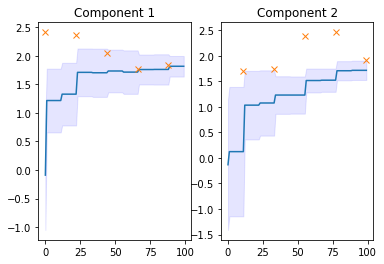

In [99]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(means[:, 0])
ax[0].plot(data[:, 0], marker='x')
ax[0].fill_between(range(sds.shape[0]), (means[:, 0] - sds[:, 0]), (means[:, 0] + sds[:, 0]), color='b', alpha=.1)
ax[0].set_title("Component 1")

ax[1].plot(means[:, 1])
ax[1].plot(data[:, 1], marker='x')
ax[1].fill_between(range(sds.shape[0]), (means[:, 1] - sds[:, 1]), (means[:, 1] + sds[:, 1]), color='b', alpha=.1)
ax[1].set_title("Component 2")

plt.show()